In [11]:
# Librerías
import pandas as pd
import numpy as np


movies_path = "ml-1m/movies.dat"
ratings_path = "ml-1m/ratings.dat"
users_path = "ml-1m/users.dat"


# Carga de los datos
users = pd.read_csv(users_path, sep="::", engine="python", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="latin-1")
movies = pd.read_csv(movies_path, sep="::", engine="python", names=["MovieID", "Title", "Genres"], encoding="latin-1")
ratings = pd.read_csv(ratings_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="latin-1")

# Mostrar primeras filas
ratings.head()



,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['user'] = user_encoder.fit_transform(ratings['UserID'])
ratings['movie'] = movie_encoder.fit_transform(ratings['MovieID'])

# Guardamos número de usuarios y películas únicos
num_users = ratings['user'].nunique()
num_movies = ratings['movie'].nunique()

num_users, num_movies


(6040, 3706)

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")


Train size: 720150
Validation size: 80017
Test size: 200042


In [14]:
import torch
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, mlp_layers=[64, 32, 16]):
        super(NCF, self).__init__()
        
        # Embeddings para GMF
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim)
        
        # Embeddings para MLP
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        mlp_input_size = 2 * embedding_dim
        mlp_layers_seq = []
        for layer_size in mlp_layers:
            mlp_layers_seq.append(nn.Linear(mlp_input_size, layer_size))
            mlp_layers_seq.append(nn.ReLU())
            mlp_input_size = layer_size
        self.mlp = nn.Sequential(*mlp_layers_seq)

        # Capa de salida combinada GMF + MLP
        self.final_layer = nn.Linear(embedding_dim + mlp_layers[-1], 1)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_user = self.user_embedding_gmf(user_ids)
        gmf_item = self.item_embedding_gmf(item_ids)
        gmf_output = gmf_user * gmf_item  # Element-wise product

        # MLP
        mlp_user = self.user_embedding_mlp(user_ids)
        mlp_item = self.item_embedding_mlp(item_ids)
        mlp_input = torch.cat((mlp_user, mlp_item), dim=-1)
        mlp_output = self.mlp(mlp_input)

        # Concatenar GMF y MLP
        final_input = torch.cat((gmf_output, mlp_output), dim=-1)
        prediction = self.final_layer(final_input)

        return prediction.squeeze()  # [batch] shape


In [15]:
from torch.utils.data import Dataset, DataLoader

# Dataset personalizado
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['movie'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].values, dtype=torch.float)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Crear datasets
train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)
test_dataset = RatingsDataset(test_data)

# Dataloaders
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [16]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# Entrenamiento y validación
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for users, items, ratings in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            optimizer.zero_grad()
            outputs = model(users, items)
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validación
        model.eval()
        val_losses = []
        with torch.no_grad():
            for users, items, ratings in val_loader:
                users, items, ratings = users.to(device), items.to(device), ratings.to(device)
                outputs = model(users, items)
                val_loss = criterion(outputs, ratings)
                val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}: Train MSE = {np.mean(train_losses):.4f}, Val MSE = {np.mean(val_losses):.4f}, Val RMSE = {np.sqrt(np.mean(val_losses)):.4f}")


In [17]:
# Comprobar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear el modelo
model = NCF(num_users=num_users, num_items=num_movies, embedding_dim=32)

# Entrenamiento
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=0.001,
    device=device
)


Epoch 1/10:   0%|          | 0/2814 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 2814/2814 [00:13<00:00, 215.23it/s]


Epoch 1: Train MSE = 1.2098, Val MSE = 0.9038, Val RMSE = 0.9507


Epoch 2/10: 100%|██████████| 2814/2814 [00:13<00:00, 206.14it/s]


Epoch 2: Train MSE = 0.8667, Val MSE = 0.8588, Val RMSE = 0.9267


Epoch 3/10: 100%|██████████| 2814/2814 [00:13<00:00, 210.90it/s]


Epoch 3: Train MSE = 0.8335, Val MSE = 0.8449, Val RMSE = 0.9192


Epoch 4/10: 100%|██████████| 2814/2814 [00:13<00:00, 207.88it/s]


Epoch 4: Train MSE = 0.8200, Val MSE = 0.8470, Val RMSE = 0.9203


Epoch 5/10: 100%|██████████| 2814/2814 [00:13<00:00, 208.04it/s]


Epoch 5: Train MSE = 0.8092, Val MSE = 0.8478, Val RMSE = 0.9208


Epoch 6/10: 100%|██████████| 2814/2814 [00:13<00:00, 208.83it/s]


Epoch 6: Train MSE = 0.7996, Val MSE = 0.8412, Val RMSE = 0.9172


Epoch 7/10: 100%|██████████| 2814/2814 [00:13<00:00, 207.86it/s]


Epoch 7: Train MSE = 0.7878, Val MSE = 0.8478, Val RMSE = 0.9208


Epoch 8/10: 100%|██████████| 2814/2814 [00:13<00:00, 201.43it/s]


Epoch 8: Train MSE = 0.7748, Val MSE = 0.8564, Val RMSE = 0.9254


Epoch 9/10: 100%|██████████| 2814/2814 [00:13<00:00, 209.90it/s]


Epoch 9: Train MSE = 0.7602, Val MSE = 0.8619, Val RMSE = 0.9284


Epoch 10/10: 100%|██████████| 2814/2814 [00:13<00:00, 204.98it/s]


Epoch 10: Train MSE = 0.7436, Val MSE = 0.8652, Val RMSE = 0.9302


In [18]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    criterion = nn.MSELoss()

    all_preds = []
    all_ratings = []

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            outputs = model(users, items)

            all_preds.extend(outputs.cpu().numpy())
            all_ratings.extend(ratings.cpu().numpy())

    all_preds = np.array(all_preds)
    all_ratings = np.array(all_ratings)

    mse = np.mean((all_preds - all_ratings) ** 2)
    rmse = np.sqrt(mse)

    print(f"Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}")
    return all_preds, all_ratings

# Ejecutar evaluación
test_preds, test_truth = evaluate_model(model, test_loader, device)


Test MSE: 0.8796, Test RMSE: 0.9379


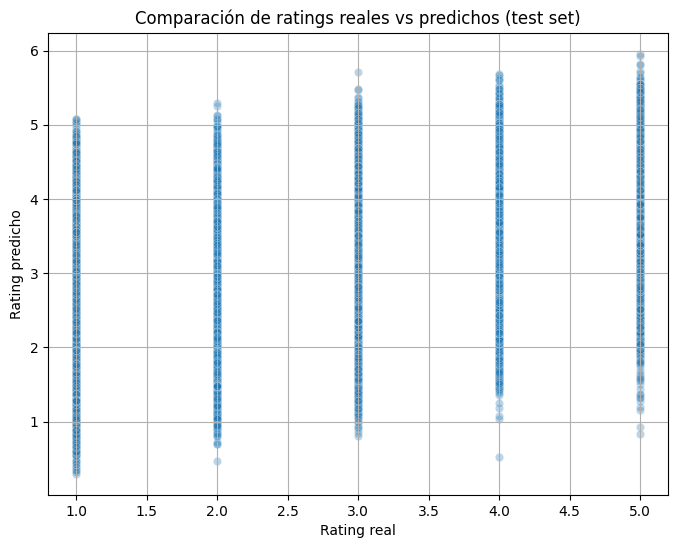

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_truth, y=test_preds, alpha=0.3)
plt.xlabel("Rating real")
plt.ylabel("Rating predicho")
plt.title("Comparación de ratings reales vs predichos (test set)")
plt.grid(True)
plt.show()
